# Solar Orbiter paper on first ICME April 2020


This is the source code for parts of Davies et al. (2021) A&A Solar Orbiter special issue.

### Figure 1, positions, in situ data Solar Orbiter (mag), Wind (mag and plasma)

In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as constb
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import heliosat

#because script is not in root directory of package
#sys.path.append('/Users/chris/python/heliocats')
sys.path.append('/home/cmoestl/pycode/heliocats')
import heliocats.data as hd
from config import data_path

from astropy.constants import au
#define AU in km
AU=au.value/1e3

## load in situ data, positions and THUX solar wind

In [2]:
#old filemag=data_path+'solo_2020_icme_april_rtn.p'
filemag=data_path+'solo_2020_icme_april_rtn.p'
sm=pickle.load(open(filemag, "rb" ) ) 

filewin=data_path+'wind_2018_2020_oct_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )

filebepi='bepi_2020_icme_april_hee.p'
bm=pickle.load(open(data_path+filebepi, "rb" ) )      

#set bepi mag to nan after Apr 21
nanind=np.where(bm.time > parse_time('2020-04-21 18:00').datetime)

bm.bt[nanind]=np.nan
bm.bx[nanind]=np.nan
bm.by[nanind]=np.nan
bm.bz[nanind]=np.nan


#same for orbiter
nanind=np.where(np.logical_and(sm.time > parse_time('2020-04-21 00:00').datetime, sm.time < parse_time('2020-04-22 00:00').datetime)  )
sm.bt[nanind]=np.nan
sm.bx[nanind]=np.nan
sm.by[nanind]=np.nan
sm.bz[nanind]=np.nan




[psp, bepi, solo, sta, earth, venus, mars, mercury,frame]= \
      pickle.load( open( '../data/positions_psp_solo_bepi_sta_planets_HEEQ_1hour.p', "rb" ))


############################# HUX

wsa=np.loadtxt('../data/thux/wsa-vmap-19apr2020.txt')
wsa_all=np.loadtxt('../data/thux/wsa-planets-missions-cr2047-cr2234.txt',skiprows=1)

#convert matlab time to matplotlib time

wsa_all_datetime=[None]*len(wsa_all)
for p in np.arange(len(wsa_all)):
        wsa_all_datetime[p]= datetime.datetime.fromordinal(wsa_all[p,0].astype(int) ) + \
        datetime.timedelta(days=wsa_all[p,0]%1) - datetime.timedelta(days = 366) 


#vEarth	vMercury	vVenus	vMars	vBepi	vPSP	vSOLO	vSTEREOA	vSTEREOB
wsa_all_earth=wsa_all[:,1]
wsa_all_solo=wsa_all[:,7]
wsa_all_sta=wsa_all[:,8]




################### THUX

wsa_thux=np.loadtxt('../data/thux/wsa-vmap-19apr2020-v2.txt')
wsa_apr_thux=np.loadtxt('../data/thux/wsa-planets-missions-19apr2020.txt',skiprows=1)

#convert matlab time to matplotlib time

wsa_apr_thux_datetime=[None]*len(wsa_apr_thux)
for p in np.arange(len(wsa_apr_thux)):
        wsa_apr_thux_datetime[p]= datetime.datetime.fromordinal(wsa_apr_thux[p,0].astype(int) ) + \
        datetime.timedelta(days=wsa_apr_thux[p,0]%1) - datetime.timedelta(days = 366) 


#vEarth	vMercury	vVenus	vMars	vBepi	vPSP	vSOLO	vSTEREOA	vSTEREOB
wsa_apr_thux_earth=wsa_apr_thux[:,1]
wsa_apr_thux_solo=wsa_apr_thux[:,7]
wsa_apr_thux_sta=wsa_apr_thux[:,8]


print('done')

done


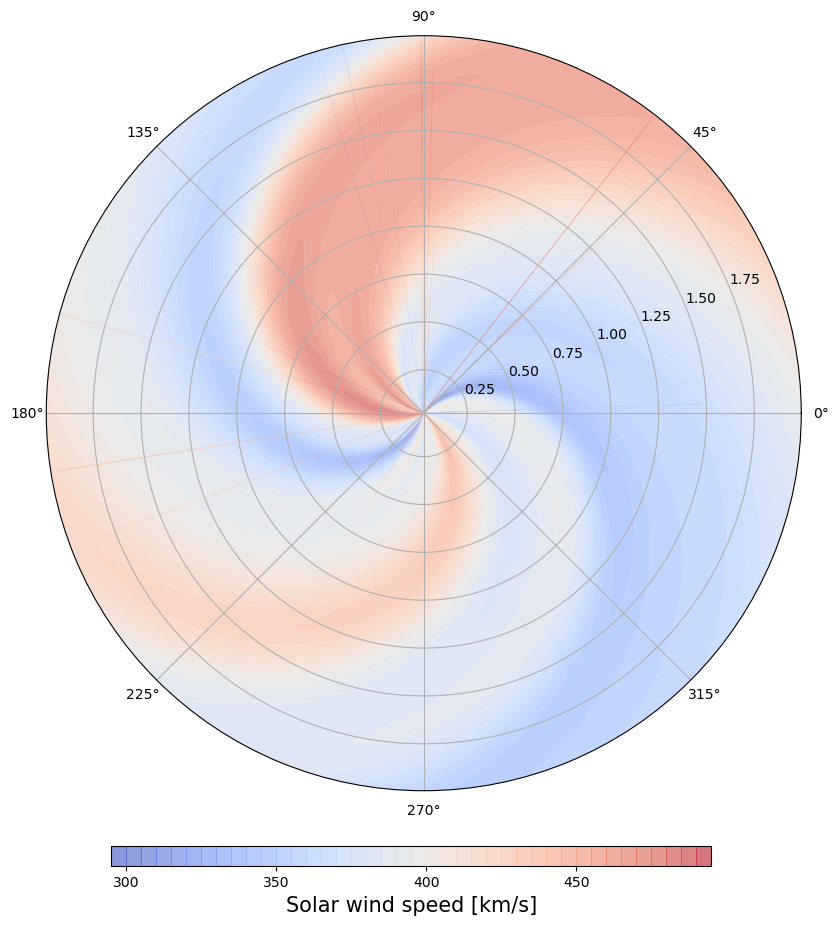

In [3]:
def plot_bgsw(ax,cbarax):

    
    #for rotation
    #k=0
    #CR 2229	2020 Mar 28	0853 start
    #k=14
    #rotSun = 27.2753
    #rotAngle = (2 * np.pi / rotSun) * k #+np.pi/2 
    #rotAngle = (2 * np.pi / rotSun) * k  

    thetaLen=180
    rLen=425
    r_sun = 695700.
    au = 149597870.
    startBGSW = 5

    #grid
    angle = np.deg2rad(np.arange(0, 362, 362 / thetaLen)) #+ np.deg2rad(-90) #+ rotAngle    
    radius = np.arange(startBGSW, rLen + startBGSW) / au * r_sun
    thetaBGSW, rBGSW = np.meshgrid(angle, radius)

    ## HUX
    
    #wsafin =copy.deepcopy(wsa)
    
    #levels = np.arange(np.round(np.min(wsafin))+1, np.max(wsafin), 5)

    #cf = ax.contourf(thetaBGSW.T, rBGSW.T, np.flip(wsafin,axis=1).T, levels,
    #                 cmap=plt.cm.get_cmap('coolwarm'), alpha=0.9,
    #                 vmin=np.min(wsafin), vmax=np.max(wsafin),antialiased=True)

    #cf = ax.contourf(thetaBGSW.T, rBGSW.T, wsafin.T,levels,
    #                 cmap=plt.cm.get_cmap('coolwarm'), alpha=0.5,antialiased=True)

    #cf = ax.contourf(thetaBGSW.T, rBGSW.T, np.flip(wsafin,axis=1).T,levels,
    #                 cmap=plt.cm.get_cmap('coolwarm'), alpha=0.5,antialiased=True)

    ##### THUX

    levels = np.arange(np.round(np.min(wsa_thux)), np.max(wsa_thux), 5)
    
    cf = ax.contourf(thetaBGSW.T, rBGSW.T, np.flip(wsa_thux,axis=1).T,levels,
                     cmap=plt.cm.get_cmap('coolwarm'),vmin=np.min(wsa_thux), 
                     vmax=np.max(wsa_thux),alpha=0.6,antialiased=True)


    
    # This is the fix for the white lines between contour levels
    #for c in cf.collections:
    #    c.set_edgecolor('face')
    #    c.set_linewidth( 0.1 ) 
        
        

    cax = plt.axes(cbarax)
    cbar = plt.colorbar(cf, cax=cax, ticks=np.arange(200, 600, 50),orientation="horizontal")
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=15)
    cbar.set_label('Solar wind speed [km/s]', fontsize=15)


    #ax.set_ylim(0, 1.2) 
    #ax.grid(False)


plt.figure(1,figsize=(10, 10),dpi=100)


ax1 = plt.subplot2grid((1, 1), (0, 0),projection='polar') 


cbarax1=[0.2, 0.05, 0.6, 0.02]

plot_bgsw(ax1,cbarax1)
#plot_bgsw(ax1,cbarax1)


## Results

In [4]:
#%matplotlib inline
#%matplotlib
#hp.plot_insitu_measure(sm, '2020-Apr-18 12:00','2020-Apr-21 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-Apr-18 12:00','2020-Apr-23 12:00', 'Wind', 'results/')




######################### solo
sicme_start_time=parse_time('2020-04-19T05:06Z').datetime
smo_start_time=parse_time('2020-04-19T08:59Z').datetime
smo_end_time=parse_time('2020-04-20T09:15Z').datetime


#unperturbed Solar Orbiter: 2020-04-19 13:56:30 to 2020-04-20 04:36:30
smo_start_un=parse_time('2020-04-19T13:56Z').datetime
smo_end_un=parse_time('2020-04-20T04:36Z').datetime


print('SolO times:',sicme_start_time, smo_start_time,smo_end_time)


print()
#index of times
sicme_start_ind=np.where(sm.time>sicme_start_time)[0][0]
smo_start_ind=np.where(sm.time>smo_start_time)[0][0]
smo_end_ind=np.where(sm.time>smo_end_time)[0][0]

smo_start_un_ind=np.where(sm.time>smo_start_un)[0][0]
smo_end_un_ind=np.where(sm.time>smo_end_un)[0][0]



print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(sm.r[sicme_start_ind],3),np.round(sm.lat[sicme_start_ind],2),np.round(sm.lon[sicme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(sm.r[smo_start_ind],3),np.round(sm.lat[smo_start_ind],2),np.round(sm.lon[smo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))


print('SolO ICME duration hours ', np.round((smo_end_time-sicme_start_time).total_seconds()/3600,2))
print('SolO sheath duration hours ', np.round((smo_start_time-sicme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_start_time).total_seconds()/3600,2))
print('SolO MO unperturbed hours ', np.round((smo_end_un-smo_start_un).total_seconds()/3600,2))
print()

print('SOLO Bmean ICME   ',np.round(np.nanmean(sm.bt[sicme_start_ind:smo_end_ind]),1))
print('SOLO Bmean sheath ',np.round(np.nanmean(sm.bt[sicme_start_ind:smo_start_ind]),1))
print('SOLO Bmean MO     ',np.round(np.nanmean(sm.bt[smo_start_ind:smo_end_ind]),1))
print('SOLO Bmean UMFR     ',np.round(np.nanmean(sm.bt[smo_start_un_ind:smo_end_un_ind]),1))
print()


print()

#arrival speed für solo laut elevohi ist 377+/-8 km/s
#und für earth 395+/-15 km/s
#bei Erde in situ 346.3 km/s

print('Solo MO unperturbed, radial size s=v*t sum data points with 1 minute resolution with hi speed 377-49 km/s ')

#use unperturbed interval
smo_radialsize_un=np.round((377-49)*(smo_end_un_ind-smo_start_un_ind)*60/AU,4)
print(smo_radialsize_un, 'AU')




print('------------------------------------------')



########################## Wind
wicme_start_time=parse_time('2020-04-20T01:34Z').datetime
wmo_start_time=parse_time('2020-04-20T07:56Z').datetime
#alternative wmo_start_time=parse_time('2020-04-20T06:37Z').datetime
wmo_end_time=parse_time('2020-04-21T11:18Z').datetime


#unperturbed: Wind: 2020-04-20 11:27:30 to 2020-04-21 02:09:30
wmo_start_un=parse_time('2020-04-20T11:28Z').datetime
#alternative wmo_start_time=parse_time('2020-04-20T06:37Z').datetime
wmo_end_un=parse_time('2020-04-21T02:10Z').datetime




#index of times
wicme_start_ind=np.where(wicme_start_time==win.time)[0][0]
wmo_start_ind=np.where(wmo_start_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]
wmo_start_un_ind=np.where(wmo_start_un==win.time)[0][0]
wmo_end_un_ind=np.where(wmo_end_un==win.time)[0][0]



print()
print('Wind times:',wicme_start_time, wmo_start_time,wmo_end_time)
print()
print('HEEQ position of Wind r/lat/lon at icme_start_time:',np.round(win.r[wicme_start_ind],3),np.round(win.lat[wicme_start_ind],2),np.round(win.lon[wicme_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_start_time:',np.round(win.r[wmo_start_ind],3),np.round(win.lat[wmo_start_ind],2),np.round(win.lon[wmo_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[wmo_end_ind],3),np.round(win.lat[wmo_end_ind],2),np.round(win.lon[wmo_end_ind],2))
print()
print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_start_time).total_seconds()/3600,2))
print('Wind sheath duration hours ', np.round((wmo_start_time-wicme_start_time).total_seconds()/3600,2))
wmo_dur=np.round((wmo_end_time-wmo_start_time).total_seconds()/3600,2)
print('Wind MO duration hours ', wmo_dur)
print('Wind MO unperturbed hours ', np.round((wmo_end_un-wmo_start_un).total_seconds()/3600,2))
print()
print('Wind Bmean ICME   ',np.round(np.nanmean(win.bt[wicme_start_ind:wmo_end_ind]),1))
print('Wind Bmean sheath ',np.round(np.nanmean(win.bt[wicme_start_ind:wmo_start_ind]),1))
print('Wind Bmean MO     ',np.round(np.nanmean(win.bt[wmo_start_ind:wmo_end_ind]),1))
print('Wind Bmean UMFR   ',np.round(np.nanmean(win.bt[wmo_start_un_ind:wmo_end_un_ind]),1))
print()
print('Wind Vmean ICME   ',np.round(np.nanmean(win.vt[wicme_start_ind:wmo_end_ind]),1))


print()
print('Wind MO unperturbed, radial size s=v*t for each timestep, sum, wind 2 minute resolution: ')
#use unperturbed interval
wmo_radialsize_un=np.round(np.sum(win.vt[wmo_start_un_ind:wmo_end_un_ind]*120/AU),5)
print(wmo_radialsize_un, 'AU')

print('------------------------------------------')





########################## Bepi
bicme_start_time=parse_time('2020-04-20T03:09Z').datetime
bmo_start_time=parse_time('2020-04-20T08:05Z').datetime
bmo_end_time=parse_time('2020-04-21T10:08Z').datetime


#unperturbed Bepi: 2020-04-20 14:03:00 to 2020-04-21 03:18:00

bmo_start_un=parse_time('2020-04-20T14:03Z').datetime
#alternative wmo_start_time=parse_time('2020-04-20T06:37Z').datetime
bmo_end_un=parse_time('2020-04-21T03:18Z').datetime


#index of times
bicme_start_ind=np.where(bicme_start_time==bm.time)[0][0]
bmo_start_ind=np.where(bmo_start_time==bm.time)[0][0]
bmo_end_ind=np.where(bmo_end_time==bm.time)[0][0]

bmo_start_un_ind=np.where(bmo_start_un==bm.time)[0][0]
bmo_end_un_ind=np.where(bmo_end_un==bm.time)[0][0]



print('Bepi times:',bicme_start_time, bmo_start_time,bmo_end_time,bmo_start_un,bmo_end_un)
print()

print('HEEQ position of Bepi r/lat/lon at icme_start_time:',np.round(bm.r[bicme_start_ind],3),np.round(bm.lat[bicme_start_ind],2),np.round(bm.lon[bicme_start_ind],2))
print('HEEQ position of Bepi r/lat/lon at mo_start_time:',np.round(bm.r[bmo_start_ind],3),np.round(bm.lat[bmo_start_ind],2),np.round(bm.lon[bmo_start_ind],2))
print('HEEQ position of Bepi r/lat/lon at mo_end_time:',np.round(bm.r[bmo_end_ind],3),np.round(bm.lat[bmo_end_ind],2),np.round(bm.lon[bmo_end_ind],2))
print()
print('Bepi ICME duration hours ', np.round((bmo_end_time-bicme_start_time).total_seconds()/3600,2))
print('Bepi sheath duration hours ', np.round((bmo_start_time-bicme_start_time).total_seconds()/3600,2))
print('Bepi MO duration hours ', np.round((bmo_end_time-bmo_start_time).total_seconds()/3600,2))
print('Bepi MO unperturbed hours ', np.round((bmo_end_un-bmo_start_un).total_seconds()/3600,2))
print()
print('Bepi Bmean ICME   ',np.round(np.nanmean(bm.bt[bicme_start_ind:bmo_end_ind]),1))
print('Bepi Bmean sheath ',np.round(np.nanmean(bm.bt[bicme_start_ind:bmo_start_ind]),1))
print('Bepi Bmean MO     ',np.round(np.nanmean(bm.bt[bmo_start_ind:bmo_end_ind]),1))
print('Bepi Bmean UMFR   ',np.round(np.nanmean(bm.bt[bmo_start_un_ind:bmo_end_un_ind]),1))
print()
print('----------------------------')
print()

SolO times: 2020-04-19 05:06:00 2020-04-19 08:59:00 2020-04-20 09:15:00

HEEQ position of SolO r/lat/lon at icme_start_time: 0.806 -3.9 -4.61
HEEQ position of SolO r/lat/lon at mo_start_time: 0.805 -3.89 -4.56
HEEQ position of SolO r/lat/lon at mo_end_time: 0.799 -3.77 -4.28
SolO ICME duration hours  28.15
SolO sheath duration hours  3.88
SolO MO duration hours  24.27
SolO MO unperturbed hours  14.67

SOLO Bmean ICME    17.2
SOLO Bmean sheath  9.9
SOLO Bmean MO      18.4
SOLO Bmean UMFR      19.2


Solo MO unperturbed, radial size s=v*t sum data points with 1 minute resolution with hi speed 377-49 km/s 
0.1159 AU
------------------------------------------

Wind times: 2020-04-20 01:34:00 2020-04-20 07:56:00 2020-04-21 11:18:00

HEEQ position of Wind r/lat/lon at icme_start_time: 0.996 -5.21 0.19
HEEQ position of Wind r/lat/lon at mo_start_time: 0.996 -5.19 0.19
HEEQ position of Wind r/lat/lon at mo_end_time: 0.996 -5.09 0.18

Wind ICME duration hours  33.73
Wind sheath duration hours  

In [5]:
print('Flux rope aspect ratio')
print()
print('from HI measurements')

########### get apex distance
#wie is da R berechnet?
#ich hab die parameter mit abgespeichert
#phi = 82°, half width = 35°, f = 0.7
#es gibt insgesamt 4 runs, die genau treffen. einer davon hat ausreißerparameter, aber die anderen drei sind sich ziemlich einig.
#stereo - earth war -75°, also ist das eine direction von 7° from earth

from scipy.io.idl import readsav
aw_data_r_file='../data/davies_2020_paper/angular_width_r.sav'
aw_data_r=readsav(aw_data_r_file)
aw_r_apex=aw_data_r['r_apex']


############ get x and y data
ar_data_file='../data/davies_2020_paper/20200414_aspectratio_long.txt'
ar_data=np.genfromtxt(ar_data_file)
#get time ...

ar_time=np.arange(len(ar_data))[1:]

#TRACK_DATE , 1 y_top, 2 y_bottom, 3 y_left, 4 y_right, 5 y_center, 6 x_top, 7 x_bottom, 8 x_left,9 x_right, 10 x_center
y_top=ar_data[:,1][1:]
y_bottom=ar_data[:,2][1:]
yex=y_top-y_bottom
yex_mean=np.mean(yex)
yex_std=np.std(yex)

x_left=ar_data[:,8][1:]
x_right=ar_data[:,9][1:]
xex=x_right-x_left

xex_mean=(np.nanmean(xex))
xex_std=(np.nanstd(xex))

x_center=ar_data[:,10][1:]


print('y')
print(yex_mean)
print(yex_std)

print()
print('x')
print(xex_mean)
print(xex_std)


print()

#https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Non-linear_combinations
covxy = np.cov(xex, yex, bias=True)[0][1]
aspect_direct=yex/xex
#boundaries with f=A/B error propagation
aspect_direct_p=yex/xex+np.sqrt((xex_std/xex)**2+  (yex_std/yex)**2+ 2*(yex_std/yex)**2*covxy/ (yex*xex) )
aspect_direct_m=yex/xex-np.sqrt((xex_std/xex)**2+  (yex_std/yex)**2+ 2*(yex_std/yex)**2*covxy/ (yex*xex) )

#plt.plot(aw_r_apex,yex_mean/xex_mean)

print('aspect ratio measurements')

print(aspect_direct)
print(aspect_direct_p)
print(aspect_direct_m)


aspect_direct_mean=np.round(np.mean(aspect_direct),2)
aspect_direct_std=np.round(np.std(aspect_direct),2)

print()
print('-------------- void aspect ratio directly from images')
print('mean of aspect ratio',aspect_direct_mean,' +/- standard ',aspect_direct_std)


print()
print('------------- void angular width')

#Tanja: angular_width = (atan(((y_top+abs(y_bottom))/2.)/x_center)/!dtor)*2

aw_calc=np.arctan(  (  yex*0.5 ) / x_center ) *2*180/np.pi
print(aw_calc)

aw_calc_mean=np.round(np.mean(aw_calc),2)
aw_calc_std=np.round(np.std(aw_calc),2)

print()
print('mean of angular width',aw_calc_mean,' +/- standard ',aw_calc_std)
#plt.plot(aw_r_apex,aw_calc)



Flux rope aspect ratio

from HI measurements
y
2.628284586584536
0.765154472686023

x
1.6688865868079077
0.7353698646998363

aspect ratio measurements
[1.84615385 1.80769231 1.65517241 2.04347826 1.92       1.48484848
 1.76666667 1.70967742 1.78787879 1.60606061 1.53846154 1.525
 2.14285714 2.14285714 1.87878788 2.         2.03225806 2.22222222
 1.97435897 1.53061224 1.8974359  1.68627451 1.97619048 1.28125
 1.3        1.08139535 1.37804878 1.43835616 1.49206349 1.5
 1.52238806 1.43283582 1.2804878  1.26436782]
[2.81650521 2.78666425 2.55362669 3.11479375 2.91853689 2.30112575
 2.60749743 2.53120447 2.54108085 2.39284729 2.20447315 2.17521969
 2.99057492 2.99057492 2.61873895 2.80372396 2.8039689  3.09459375
 2.58361389 2.0520589  2.51397427 2.16880894 2.53959951 1.70490469
 1.68298568 1.41897969 1.69511951 1.7899509  1.89614175 1.86146909
 1.89860162 1.81776261 1.60744067 1.57361056]
[0.87580248 0.82872037 0.75671814 0.97216277 0.92146311 0.66857121
 0.9258359  0.88815037 1.03467672 0

## Figure aspect ratio

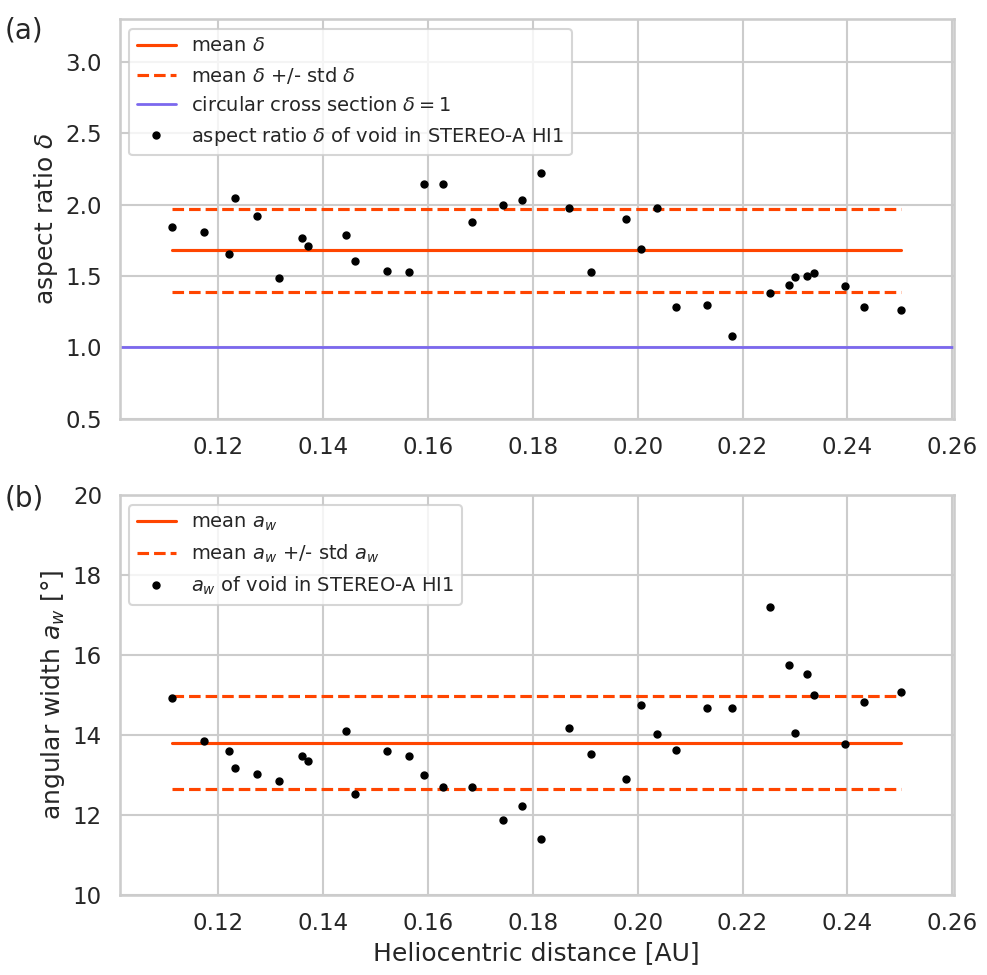

In [8]:
sns.set_context("talk")     
#sns.set_style('darkgrid')

sns.set_style('whitegrid')
#sns.set_style("ticks",{'grid.linestyle': '--'})
plt.figure(10,figsize=(10, 10),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 1), (1, 0))  #solo b
ax2 = plt.subplot2grid((2, 1), (0, 0))  #bepib




#ax2.plot(aw_r_apex,xex)
#ax2.plot(aw_r_apex,yex)

ax2.plot(np.arange(np.min(aw_r_apex),np.max(aw_r_apex),0.001),np.zeros(140)+aspect_direct_mean,color='orangered',label='mean $\delta$')
ax2.plot(np.arange(np.min(aw_r_apex),np.max(aw_r_apex),0.001),np.zeros(140)+aspect_direct_mean+aspect_direct_std,color='orangered',linestyle='--',label='mean $\delta$ +/- std $\delta$')
ax2.plot(np.arange(np.min(aw_r_apex),np.max(aw_r_apex),0.001),np.zeros(140)+aspect_direct_mean-aspect_direct_std,color='orangered',linestyle='--')
ax2.plot(np.arange(0,1,0.1),np.zeros(10)+1,color='mediumslateblue',linestyle='-',lw=2,label='circular cross section $\delta=1$')

ax2.plot(aw_r_apex,yex/xex,'ok',markersize=5,label='aspect ratio $\delta$ of void in STEREO-A HI1')


ax2.legend(loc=2,fontsize=14)

ax2.set_ylabel('aspect ratio $\delta$')
ax2.set_ylim(0.5,3.3)
ax2.set_xlim(np.min(aw_r_apex)-0.01,np.max(aw_r_apex)+0.01)




ax1.plot(np.arange(np.min(aw_r_apex),np.max(aw_r_apex),0.001),np.zeros(140)+np.mean(aw_calc),color='orangered',label='mean $a_w$')
ax1.plot(np.arange(np.min(aw_r_apex),np.max(aw_r_apex),0.001),np.zeros(140)+np.mean(aw_calc)+np.std(aw_calc),color='orangered',linestyle='--',label='mean $a_w$ +/- std $a_w$')
ax1.plot(np.arange(np.min(aw_r_apex),np.max(aw_r_apex),0.001),np.zeros(140)+np.mean(aw_calc)-np.std(aw_calc),color='orangered',linestyle='--')


ax1.plot(aw_r_apex,aw_calc,'ok',markersize=5,label='$a_w$ of void in STEREO-A HI1')
ax1.legend(loc=2,fontsize=14)
ax1.set_ylabel('angular width $a_w$ [°]')
ax1.set_ylim(10,20)
ax1.set_xlim(np.min(aw_r_apex)-0.01,np.max(aw_r_apex)+0.01)
ax1.set_xlabel('Heliocentric distance [AU]')




plt.tight_layout()

plt.annotate('(a)',[0.005,0.96],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.005,0.48],xycoords='figure fraction',fontsize=20)

plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure_aspect_aw.png',dpi=300)
plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure_aspect_aw.pdf')

In [7]:

print()
print('Aspect ratio at 1 AU from HI angular width measurements')
print()
from scipy.io.idl import readsav
aw_data_file='../data/davies_2020_paper/angular_width.sav'
aw_data=readsav(aw_data_file)


aw_mean=np.round(np.mean(aw_data['angular_width']),2)
aw_std=np.round(np.std(aw_data['angular_width']),2)

print('mean aw',aw_mean, ' +/- ',aw_std )
print('(constant angular width = self similar expansion)')

############################### with 1 AU circle
d_lat=np.round(2*np.pi/(360/aw_mean),3)
d_lat_p=np.round(2*np.pi/(360/(aw_mean+aw_std)),3)
d_lat_m=np.round(2*np.pi/(360/(aw_mean-aw_std)),3)


print('d_latitude',d_lat, 'AU, range:',d_lat_m,' - ',d_lat_p,'AU')
print('d_unperturbed',wmo_radialsize_un,'AU')

aspect_ratio_void=np.round(d_lat/wmo_radialsize_un,2)
aspect_ratio_void_p=np.round(d_lat_p/wmo_radialsize_un,2)
aspect_ratio_void_m=np.round(d_lat_m/wmo_radialsize_un,2)

print('aspect_ratio with 1 AU circle',aspect_ratio_void, 'range:',aspect_ratio_void_p,aspect_ratio_void_m)
print()

############################### with straight vertical line at 1 AU

d_lat2  =np.round(  2*np.tan(aw_mean/2*np.pi/180)   ,3)
d_lat2_p=np.round(  2*np.tan((aw_mean+aw_std)/2*np.pi/180)   ,3)
d_lat2_m=np.round(  2*np.tan((aw_mean-aw_std)/2*np.pi/180)   ,3)

print('d_latitude2',d_lat2, 'AU, range:',d_lat2_m,' - ',d_lat2_p,'AU')
print('d_unperturbed',wmo_radialsize_un,'AU')

aspect_ratio_void2  =np.round(d_lat2 /wmo_radialsize_un,2)
aspect_ratio_void2_p=np.round(d_lat2_p/wmo_radialsize_un,2)
aspect_ratio_void2_m=np.round(d_lat2_m/wmo_radialsize_un,2)

print('aspect_ratio with 1 AU straight vertical line',aspect_ratio_void2, 'range:',aspect_ratio_void2_p,aspect_ratio_void2_m)
print()



print()
print()

aw_full=45
print('full extent degree from HELCATS catalog', aw_full)
d_lat_full=np.round(2*np.pi/(360/aw_full),2)
print('d_latitude_full',d_lat_full)

aspect_ratio_full=aspect_ratio_void=np.round(d_lat_full/wmo_radialsize_un,2)
print('aspect_ratio full',aspect_ratio_full)


Aspect ratio at 1 AU from HI angular width measurements

mean aw 13.81  +/-  1.17
(constant angular width = self similar expansion)
d_latitude 0.241 AU, range: 0.221  -  0.261 AU
d_unperturbed 0.12097 AU
aspect_ratio with 1 AU circle 1.99 range: 2.16 1.83

d_latitude2 0.242 AU, range: 0.222  -  0.263 AU
d_unperturbed 0.12097 AU
aspect_ratio with 1 AU straight vertical line 2.0 range: 2.17 1.84



full extent degree from HELCATS catalog 45
d_latitude_full 0.79
aspect_ratio full 6.53


### Make Figure 1 plot 

HEEQ
current frame_time_num 2020-04-20 00:00:00+00:00


/home/cmoestl/miniconda/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


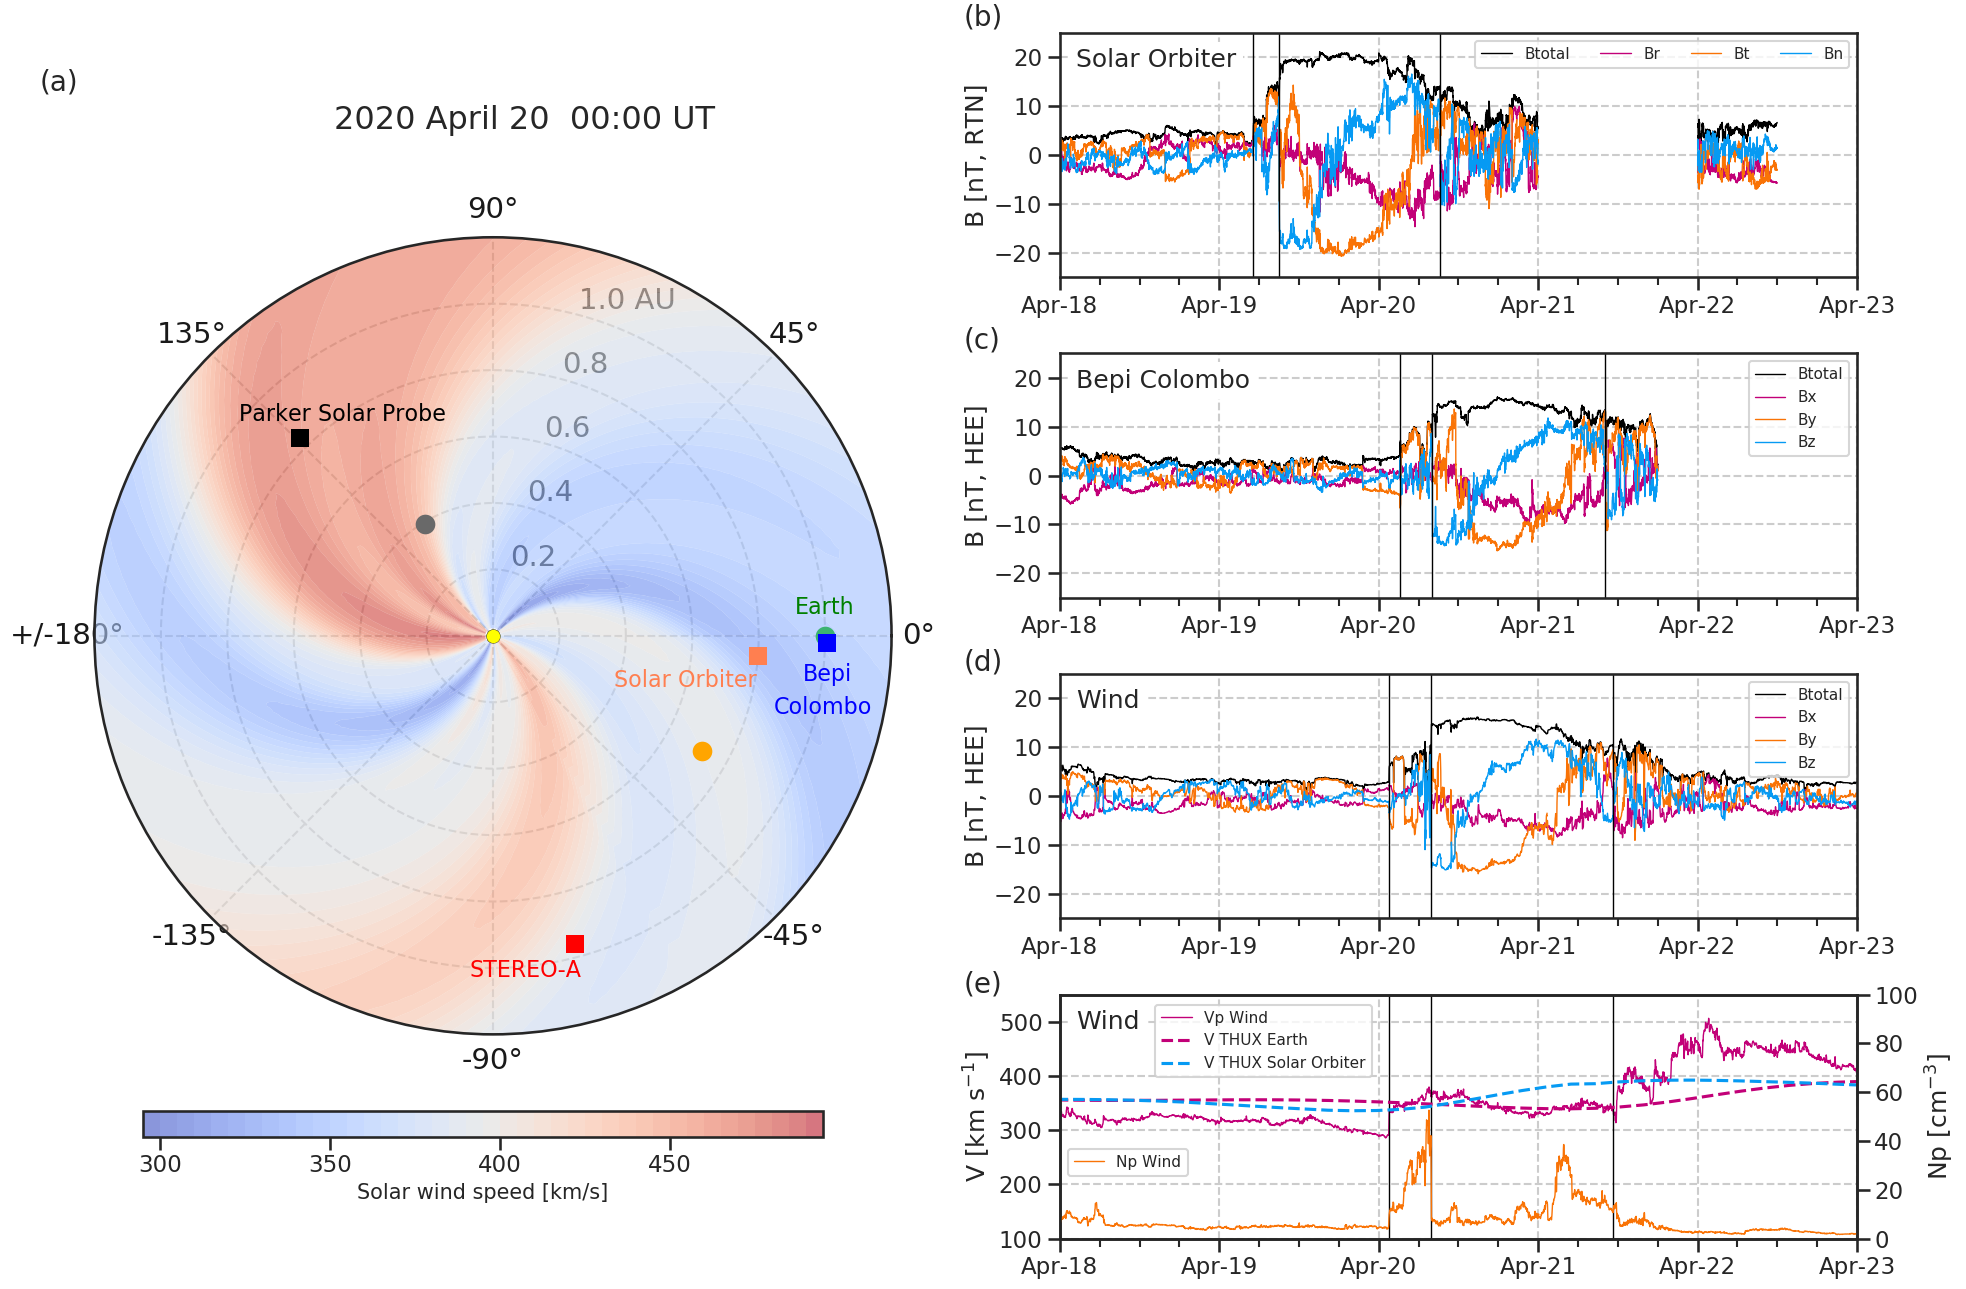

In [9]:
sns.set_context("talk")     
#sns.set_style('darkgrid')
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan


plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,23)
blim=25





plt.figure(1,figsize=(20, 13),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((4, 2), (0, 1))  #solo b
ax2 = plt.subplot2grid((4, 2), (1, 1))  #bepib
ax3 = plt.subplot2grid((4, 2), (2, 1))  #wind b
ax4 = plt.subplot2grid((4, 2), (3, 1))  #wind v


ax5 = plt.subplot2grid((4, 2), (0, 0), rowspan=4, projection='polar') #positions


#########################################################################
backcolor='black'
psp_color='black'
bepi_color='blue'
solo_color='coral'

symsize_planet=200
symsize_spacecraft=150
fsize=20
plot_orbit=True
fadeind=150

plot_parker=False
plot_hux=True


AUkm=149597870.7   

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

#Coordinate System
#frame='HCI'
frame='HEEQ'
print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

frame_time_num=mdates.date2num(parse_time('2020-Apr-20').datetime)
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp.time
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi.time
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo.time
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta.time
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth.time
earth_timeind=np.argmin(abs(dct))


ax5.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
ax5.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
ax5.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
ax5.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
ax5.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)

ax5.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', alpha=1,lw=0,zorder=3)
ax5.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
ax5.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)

#set axes and grid
ax5.set_theta_zero_location('E')
#plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/-180\u00b0',u'-135\u00b0',u'-90\u00b0',u'-45\u00b0'), fmt='%d',fontsize=fsize+1,color=backcolor, alpha=0.9,zorder=4)

#plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
plt.rgrids((0.2,0.4,0.6,0.8,1.0),('0.2','0.4','0.6','0.8','1.0 AU'),angle=75, fontsize=fsize+1,alpha=0.9, color=backcolor,zorder=4)

#ax.set_ylim(0, 1.75) #with Mars
ax5.set_ylim(0, 1.2) 

#Sun
ax5.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


#spacecraft labels
ax5.text(psp.lon[psp_timeind]-0.2,psp.r[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(solo.lon[solo_timeind]-0.05,solo.r[solo_timeind],'Solar Orbiter', color=solo_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax5.text(bepi.lon[bepi_timeind]-0.06,bepi.r[bepi_timeind],'Bepi', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(bepi.lon[bepi_timeind]-0.16,bepi.r[bepi_timeind],'Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(sta.lon[sta_timeind]-0.16,sta.r[sta_timeind]+0.01,'STEREO-A', color='red', ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(earth.lon[earth_timeind]+0.12,earth.r[earth_timeind],'Earth', color='green', ha='center',fontsize=fsize-4,verticalalignment='top')


if plot_hux:
    cbarax=[0.08,0.13,0.34,0.02]
    plot_bgsw(ax5,cbarax)
   
    

#parker spiral
if plot_parker:
    for q in np.arange(0,12):
        omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
        v=400/AUkm #km/s
        r0=695000/AUkm
        r=v/omega*theta+r0*7
        ax5.plot(-theta+np.deg2rad(0+(360/24.47)*1+360/12*q), r, alpha=0.4, lw=0.8,color='black',zorder=1)



#---------------------------------------- Solo MAG

ax1.plot(sm.time, sm.bt, "k-", lw=1,label='Btotal')
ax1.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]')
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=1,ncol=4,fontsize=11)
ax1.grid(True)
ax1.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1/24*6))

#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
#         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)



#--------------------------------------- Bepi MPO MAG

ax2.plot(bm.time, bm.bt, "k-", lw=1,label='Btotal')
ax2.plot(bm.time, bm.bx,'-r', color="xkcd:magenta",linewidth=1,label='Bx')
ax2.plot(bm.time, bm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(bm.time, bm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')

    
#plot vertical lines
ax2.plot_date([bicme_start_time,bicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([bmo_start_time,bmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([bmo_end_time,bmo_end_time],[-500,500],'-k',linewidth=1)            

ax2.set_ylabel('B [nT, HEE]')
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.legend(loc=1,ncol=1,fontsize=11)
ax2.grid(True)
ax2.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1/24*6))




############################## Wind MFI
    
#plt.title('Wind MFI')

ax3.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
ax3.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='Bx')
ax3.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax3.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')


#plot vertical lines
ax3.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax3.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax3.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            


ax3.set_ylabel('B [nT, HEE]')
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.legend(loc=1,ncol=1,fontsize=11)
ax3.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1/24*6))
ax3.grid(True)



#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
#         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)


#plt.tight_layout()



############################## Wind SWE

ax4.plot(win.time, win.vt, color="xkcd:magenta",linewidth=1,label='Vp Wind')

ax4.plot_date([wicme_start_time,wicme_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_start_time,wmo_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_end_time,wmo_end_time],[-500,1000],'-k',linewidth=1)            

ax4.set_ylabel('V [km $\mathrm{s^{-1}}$]')
ax4.set_xlim(plotstart,plotend)
ax4.set_ylim(100,550)
ax4.grid(True)


#HUX
#ax4.plot_date(wsa_all_datetime, wsa_all_earth,'-k')

#THUX
ax4.plot_date(wsa_apr_thux_datetime, wsa_apr_thux_earth,linestyle='--',markersize=0,color="xkcd:magenta",label='V THUX Earth')
ax4.plot_date(wsa_apr_thux_datetime, wsa_apr_thux_solo,linestyle='--',markersize=0,color="xkcd:azure", label='V THUX Solar Orbiter')

ax4.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1/24*6))
#ax4.xaxis.grid(True, which='minor')

ax4.legend(loc=2,bbox_to_anchor=(0.11,0.99),fontsize=11)




#density
ax5=ax4.twinx()
ax5.plot(win.time, win.np, color="xkcd:orange", lw=1,label='Np Wind')
ax5.set_ylim(0,100)
ax5.set_ylabel('Np $[\mathrm{cm^{-3}}]$')


ax5.legend(loc=2,bbox_to_anchor=(0.0,0.4),fontsize=11)

ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )




############################### other settings


#ax1.set_xticklabels([])
#ax2.set_xticklabels([])
#ax3.set_xticklabels([])
ax1.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
ax2.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
ax3.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )




plt.tight_layout()

#annotations

vshift=0.25
plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.49,0.98],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.49,0.98-vshift*1],xycoords='figure fraction',fontsize=20)
plt.annotate('(d)',[0.49,0.98-vshift*2],xycoords='figure fraction',fontsize=20)
plt.annotate('(e)',[0.49,0.98-vshift*3],xycoords='figure fraction',fontsize=20)


ax1.text(0.02,0.86,'Solar Orbiter',transform=ax1.transAxes,fontsize=18,bbox=dict(facecolor='white', alpha=1))
ax2.text(0.02,0.86,'Bepi Colombo',transform=ax2.transAxes,fontsize=18, bbox=dict(facecolor='white', alpha=1))
ax3.text(0.02,0.86,'Wind',transform=ax3.transAxes,fontsize=18,bbox=dict(facecolor='white', alpha=1))
ax4.text(0.02,0.86,'Wind',transform=ax4.transAxes,fontsize=18,bbox=dict(facecolor='white', alpha=1))



#time
#ax5.text(1.4,1.3,mdates.num2date(frame_time_num).strftime("%Y %B %d  %H:%M")+' UT',fontsize=fsize+3, ha='left',c='black')
plt.annotate(mdates.num2date(frame_time_num).strftime("%Y %B %d  %H:%M")+' UT',[0.17,0.90],xycoords='figure fraction',fontsize=23)


#for ticks in polar plot may use
#https://stackoverrun.com/de/q/5522696


plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview4.png')
plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview4.pdf')

### 

### Make previous plot without Bepi

HEEQ
current frame_time_num 2020-04-20 00:00:00+00:00


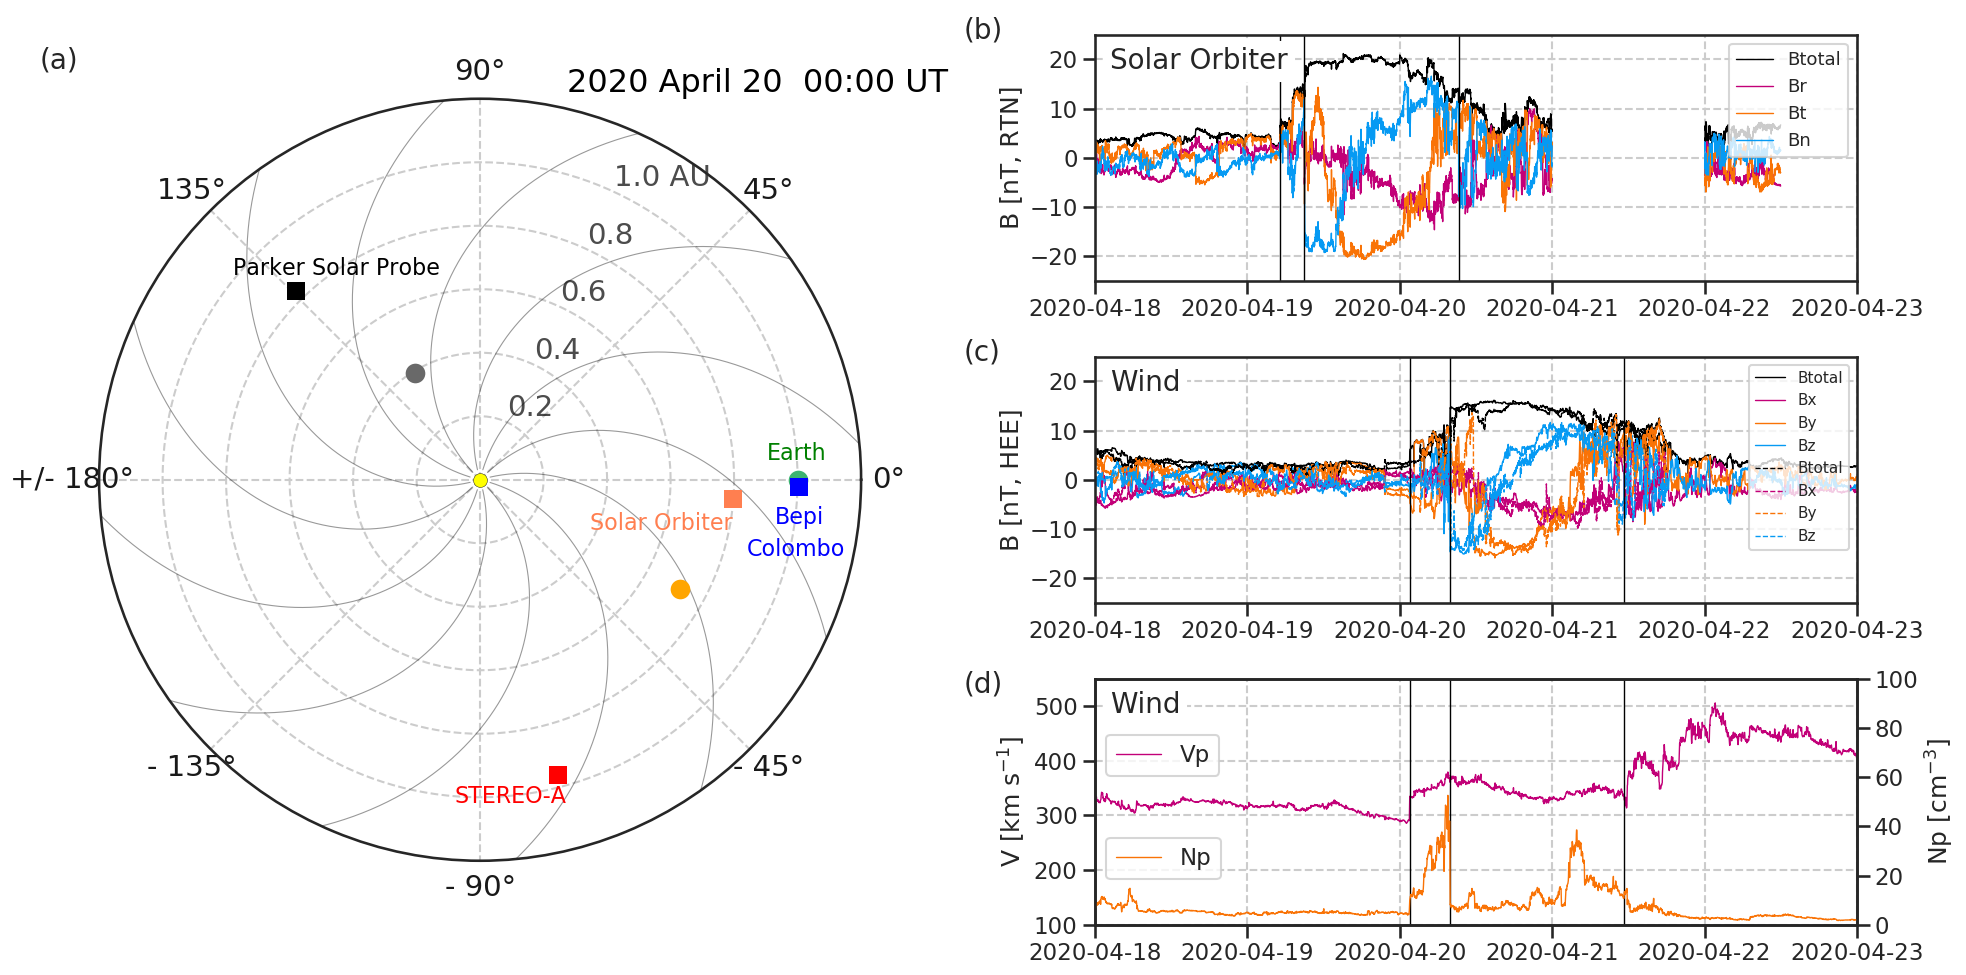

In [6]:
sns.set_context("talk")     
#sns.set_style('darkgrid')
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})



#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan


plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,23)
blim=25

plt.figure(1,figsize=(20, 10),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((3, 2), (0, 1))  #solo b
ax2 = plt.subplot2grid((3, 2), (1, 1))  #wind b
ax4 = plt.subplot2grid((3, 2), (2, 1))  #wind v
ax3 = plt.subplot2grid((3, 2), (0, 0), rowspan=3, projection='polar') #positions


#########################################################################
backcolor='black'
psp_color='black'
bepi_color='blue'
solo_color='coral'

symsize_planet=200
symsize_spacecraft=150
fsize=20
plot_orbit=True
fadeind=150

plot_parker=True

AUkm=149597870.7   

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

#Coordinate System
#frame='HCI'
frame='HEEQ'
print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

frame_time_num=mdates.date2num(parse_time('2020-Apr-20').datetime)
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp.time
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi.time
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo.time
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta.time
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth.time
earth_timeind=np.argmin(abs(dct))


ax3.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
ax3.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
ax3.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
ax3.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
ax3.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)

ax3.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', alpha=1,lw=0,zorder=3)
ax3.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
ax3.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
 

#parker spiral
if plot_parker:
    for q in np.arange(0,12):
        omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
        v=400/AUkm #km/s
        r0=695000/AUkm
        r=v/omega*theta+r0*7
        ax3.plot(-theta+np.deg2rad(0+(360/24.47)*1+360/12*q), r, alpha=0.4, lw=0.8,color='black',zorder=1)

#set axes and grid
ax3.set_theta_zero_location('E')
#plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize+1,color=backcolor, alpha=0.9,zorder=4)

#plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
plt.rgrids((0.2,0.4,0.6,0.8,1.0),('0.2','0.4','0.6','0.8','1.0 AU'),angle=65, fontsize=fsize+1,alpha=0.7, color=backcolor)

#ax.set_ylim(0, 1.75) #with Mars
ax3.set_ylim(0, 1.2) 

#Sun
ax3.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)



#spacecraft labels
ax3.text(psp.lon[psp_timeind]-0.2,psp.r[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(solo.lon[solo_timeind]-0.05,solo.r[solo_timeind],'Solar Orbiter', color=solo_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax3.text(bepi.lon[bepi_timeind]-0.06,bepi.r[bepi_timeind],'Bepi', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(bepi.lon[bepi_timeind]-0.16,bepi.r[bepi_timeind],'Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(sta.lon[sta_timeind]-0.16,sta.r[sta_timeind],'STEREO-A', color='red', ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(earth.lon[earth_timeind]+0.12,earth.r[earth_timeind],'Earth', color='green', ha='center',fontsize=fsize-4,verticalalignment='top')



#time
ax3.text(1.35,1.25,mdates.num2date(frame_time_num).strftime("%Y %B %d  %H:%M")+' UT',fontsize=fsize+3, ha='left',c='black')






#################### Solo MAG

ax1.plot(sm.time, sm.bt, "k-", lw=1,label='Btotal')
ax1.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]')
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=1,ncol=1,fontsize=13)
ax1.grid(True)


#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
#         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)

 
############################## Wind MFI
    
#plt.title('Wind MFI')

ax2.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='Bx')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')

ax2.plot(bm.time, bm.bt, "k--", lw=1,label='Btotal')
ax2.plot(bm.time, bm.bx,'--r', color="xkcd:magenta",linewidth=1,label='Bx')
ax2.plot(bm.time, bm.by, "g--", color="xkcd:orange", lw=1,label='By')
ax2.plot(bm.time, bm.bz, "b--", color="xkcd:azure", lw=1,label='Bz')


#plot vertical lines
ax2.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            

ax2.set_ylabel('B [nT, HEE]')
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.legend(loc=1,ncol=1,fontsize=11)
ax2.grid(True)

#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
#         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)


#plt.tight_layout()



############################## Wind SWE


#speed
ax4.plot(win.time, win.vt, color="xkcd:magenta",linewidth=1,label='Vp')

ax4.plot_date([wicme_start_time,wicme_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_start_time,wmo_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_end_time,wmo_end_time],[-500,1000],'-k',linewidth=1)            

ax4.set_ylabel('V [km $\mathrm{s^{-1}}$]')
ax4.set_xlim(plotstart,plotend)
ax4.set_ylim(100,550)
ax4.grid(True)



#density
ax5=ax4.twinx()
ax5.plot(win.time, win.np, color="xkcd:orange", lw=1,label='Np')
ax5.set_ylim(0,100)
ax5.set_ylabel('Np $[\mathrm{cm^{-3}}]$')

ax4.legend(loc=2,bbox_to_anchor=(0.0,0.82))
ax5.legend(loc=2,bbox_to_anchor=(0.0,0.4))



plt.tight_layout()

#annotations

plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.49,0.96],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.49,0.63],xycoords='figure fraction',fontsize=20)
plt.annotate('(d)',[0.49,0.29],xycoords='figure fraction',fontsize=20)

ax2.text(0.02,0.86,'Wind',transform=ax2.transAxes,fontsize=20, bbox=dict(facecolor='white', alpha=1))
ax4.text(0.02,0.86,'Wind',transform=ax4.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))
ax1.text(0.02,0.86,'Solar Orbiter',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))

plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview.png')
plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview.pdf')